In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
anime_list_pd = pd.read_csv("..\data\AnimeList.csv")

In [3]:
anime_list_pd.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme'],
      dtype='object')

# Renaming column RANK as ANIME_RANK

In [5]:
# type(anime_list_pd.rank)  --> method
anime_list_pd = anime_list_pd.rename(columns={'rank': 'anime_rank'}) #--> renaming column rank to anim_rank, as rank is a function in pandas
anime_list_pd.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'anime_rank', 'popularity', 'members', 'favorites',
       'background', 'premiered', 'broadcast', 'related', 'producer',
       'licensor', 'studio', 'genre', 'opening_theme', 'ending_theme'],
      dtype='object')

# Identifying primary and surrogate columns

In [6]:
#verify if therea are duplicate values in column anime_id
#duplicated will identify duplicates on anime_id, and will return T or F for each record. output type is series
# to_frame will convert series to data frame, the reason i am doing is to name the columns and apply filter
#i am not sure how to filter unnamed series.
anime_dup=anime_list_pd.duplicated("anime_id").to_frame(name="dups")
anime_dup[anime_dup.dups==True].count(),  anime_dup[anime_dup.dups==False].count()
#There are no duplicates in field anime_id

(dups    0
 dtype: int64, dups    14478
 dtype: int64)

In [7]:
#verify if therea are duplicate values in column title
anime_dup=anime_list_pd.duplicated("title").to_frame("dups")
anime_dup[anime_dup.dups==True].count(),  anime_dup[anime_dup.dups==False].count()
#looks like there is one duplicate title, try to identify it

(dups    1
 dtype: int64, dups    14477
 dtype: int64)

In [8]:
#identifying the duplicate record
anime_list_pd.groupby('title').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False).head()
# i am curious what is the significance of [['anime_id']]

,anime_id
title,
Hinamatsuri,2
"""0""",1
Owari no Seraph: Nagoya Kessen-hen - Owaranai Seraph - Nagoya Kessen-hen,1
Outbreak Company,1
Outlanders,1


In [9]:
#viewing the duplicate record
anime_list_pd[anime_list_pd.title=='Hinamatsuri']
#column "type" has different values, OVA means original video animation (released directly in dvd) and TV is a series
#so we can use anime_id as surrogate key and combination of title and type as primary keys

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
1091,36296,Hinamatsuri,NaN,ヒナまつり,Hina Festival,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Currently Airing,...,NaN,Spring 2018,Fridays at 21:00 (JST),"{'Adaptation': [{'mal_id': 36413, 'type': 'man...","Magic Capsule, Nippon Columbia",Funimation,feel.,"Sci-Fi, Slice of Life, Comedy, Supernatural, S...","['""Distance"" Rie Murakawa']","['""Sake to Ikura to 893 to Musume (鮭とイクラと893と娘..."
10841,35102,Hinamatsuri,NaN,ひなまつり,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Other,1,Finished Airing,...,NaN,NaN,NaN,[],NaN,NaN,NaN,"Historical, Kids",[],[]


# Calculating percentage of records per each TYPE

In [10]:
total = anime_list_pd['anime_id'].count()
type_avg=anime_list_pd.groupby(by='type').count()[['anime_id']].sort_values(by='anime_id', ascending=False)
type_avg['avg'] = (type_avg['anime_id']*100/total).round(2)
#Please let me know if there is any other way of calculating average???????????????????
#?????????????????????????????????????????????????????????????????????????????????????

In [11]:
type_avg

,anime_id,avg
type,,
TV,4271,29.50
OVA,3612,24.95
Movie,2624,18.12
Special,1948,13.45
ONA,1144,7.90
Music,849,5.86
Unknown,30,0.21


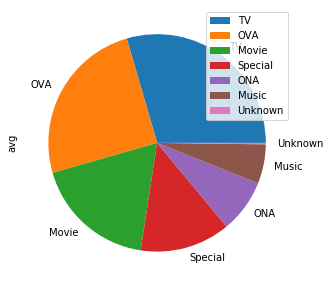

In [12]:
plot=type_avg.plot.pie(y='avg', figsize=(5,5))

# Calculating percentage of records for each Genre

In [13]:
anime_genre=anime_list_pd.groupby(by='genre').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False)
anime_genre.head()

,anime_id
genre,
Hentai,868
Comedy,590
Music,533
Kids,285
Slice of Life,166


In [15]:
anime_genre.tail()
#if you observe below records, there are multiple genres in each genre, i tried to split each into sepereate records
# and find out counts of each genre exactly, but i couldnt, this count is not required anywhere, just for statistincs purpose
# can you please suggest a way to do it ?????????????????
#?????????????????????????????????????????????????????????????????????????????????????????????

,anime_id
genre,
"Action, Game, Sci-Fi, Shounen",1
"Comedy, Josei, Music, Romance, Slice of Life",1
"Action, Game, Sci-Fi, School",1
"Comedy, Josei, School, Slice of Life",1
"Comedy, Ecchi, Harem, Magic, Romance",1


# Filtering (removing) records for which some columns have Null values

# 1 Genre

In [16]:
#anime_genre.reset_index(level=0, inplace=True) --> this will convert index column into normal column and will create a default index
#anime_genre=anime_genre.drop(columns=['genre']) --> this will drop a column
#anime_list_pd[anime_list_pd.anime_id==17813].genre.isna()
anime_list_pd[(anime_list_pd.genre.isna()==True) | (anime_list_pd.genre=='')].anime_id.count()
#there are 64 records with no genre type, we have to remove these

64

In [17]:
anime_list_pd.shape

(14478, 31)

In [20]:
# ***********filter condition 1***********************************************************************
anime_list_pd = anime_list_pd[(anime_list_pd.genre.isna()==False) & (anime_list_pd.genre!='')]

In [21]:
anime_list_pd.shape

(14414, 31)

# 2 Rating

In [22]:
anime_list_pd.groupby(by='rating').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False)
# There are 531 records with None rating, there is possibility that these might have nudity so it is better to remove them.

,anime_id
rating,
PG-13 - Teens 13 or older,5018
G - All Ages,4496
PG - Children,1277
Rx - Hentai,1219
R - 17+ (violence & profanity),996
R+ - Mild Nudity,877
None,531


In [24]:
# ***********filter condition 1 & 2***********************************************************************
anime_list_pd = anime_list_pd[(anime_list_pd.genre.isna()==False) & (anime_list_pd.genre!='') & (anime_list_pd.rating!='None')]
anime_list_pd.shape

(13883, 31)

In [25]:
anime_list_pd.groupby(by='rating').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False)

,anime_id
rating,
PG-13 - Teens 13 or older,5018
G - All Ages,4496
PG - Children,1277
Rx - Hentai,1219
R - 17+ (violence & profanity),996
R+ - Mild Nudity,877


# 3 Status

In [26]:
anime_list_pd.groupby(by='status').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False)
# there are 151 animes which are not yet aired, we have to remove those

,anime_id
status,
Finished Airing,13398
Currently Airing,334
Not yet aired,151


In [27]:
# ***********filter condition 1, 2 & 3***********************************************************************
anime_list_pd = anime_list_pd[(anime_list_pd.genre.isna()==False) & (anime_list_pd.genre!='') & (anime_list_pd.rating!='None') & (anime_list_pd.status!='Not yet aired')]
anime_list_pd.shape


(13732, 31)

In [28]:
anime_list_pd.groupby(by='status').count()[['anime_id']].sort_values(by=['anime_id'], ascending=False)

,anime_id
status,
Finished Airing,13398
Currently Airing,334


# Transforming data in few columns

# 1 Score

In [30]:
#to check if there are nans in socre
anime_list_pd[anime_list_pd.score.isna()==True]
#There are no nans in score

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme


In [32]:
anime_list_pd.groupby(by='score').count()[['anime_id']].sort_values(by='score', ascending=False).head()
#There are 4 animes with score=10

,anime_id
score,
10.00,4
9.52,1
9.50,2
9.25,1
9.20,1


In [34]:
#Trying to find relation b/w score and scored_by
anime_list_pd.groupby(by=['score', 'scored_by']).count()[['anime_id']].sort_values(by=['score', 'scored_by'],ascending=False).head()
#if you see all the top 4 animes have scored_by=1. i think we cannot consider these as top animes

,,anime_id
score,scored_by,
10.00,1,4
9.52,33,1
9.50,2,2
9.25,733592,1
9.20,5,1


In [36]:
anime_list_pd[anime_list_pd.scored_by<10].anime_id.count() 
#there are 895 records with users scored by less than 10 people, for all these i am updating score to 0

895

In [37]:
# ************ transformation 1 **************************************************************************
# changing score to 0, for all records for whcih scored_by<10
anime_list_pd.loc[(anime_list_pd.scored_by<10),'score']='0.00'

In [38]:
anime_list_pd.groupby(by=['score', 'scored_by']).count()[['anime_id']].sort_values(by=['score', 'scored_by'],ascending=False).head()

anime_id
score scored_by          
0.00  9               126
      8               144
      7               133
      6               125
      5               132

In [39]:
anime_list_pd[anime_list_pd.scored_by<10].groupby(by='score').count()[['anime_id']]

,anime_id
score,
0.00,895


# 2 Anime Rank

In [42]:
anime_list_pd.groupby(by='anime_rank').count()[['anime_id']].sort_values(by=['anime_rank'], ascending=True).head()

#lower the rank better the anime, but there is 1 records with rank =0, which are not better anime, its just default values

,anime_id
anime_rank,
0.0,1
1.0,1
2.0,1
3.0,1
4.0,1


In [45]:
anime_list_pd[anime_list_pd.anime_rank==0]
# i justed read review about this i dont think it is top anime, so zero is default value

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,20261,W-Tails Cat: A Strange Presence,NaN,W・TAILS CAT - A STRANGE PRESENCE,W Tails Cat: A Strange Presence,https://myanimelist.cdn-dena.com/images/anime/...,ONA,Other,7,Finished Airing,...,NaN,NaN,NaN,[],NaN,NaN,NaN,"Action, Mecha, Military, Hentai, Sci-Fi, Police",[],[]


In [46]:
anime_list_pd[anime_list_pd.anime_rank.isnull()==True].count().anime_id 
# there are 1244 records with nulls

1244

In [47]:
# we will convert these 1244 records into 0 
anime_list_pd['anime_rank']=anime_list_pd.anime_rank.fillna(0)

In [48]:
anime_list_pd[anime_list_pd.anime_rank.isnull()==True].count().anime_id 

0

# 3 Popularity

In [49]:
anime_list_pd.groupby(by='popularity').count()[['anime_id']].sort_values(by='anime_id',ascending=False).head()
#popularity also has duplicate values



,anime_id
popularity,
9537,4
6511,4
6104,4
2870,4
5761,3


In [50]:
#need to find out nans
anime_list_pd[anime_list_pd.popularity.isna()==True].head() 
#popularity does not have any nulls in it. so when rank is 0, we can consider popularity

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme


In [53]:
#1 record has popularity 0 and also anime_rank 0, but this has valid score.
anime_list_pd[anime_list_pd.popularity==0][['popularity', 'anime_rank', 'score']]

,popularity,anime_rank,score
0,0,0.0,6.09


# Resetting Index

In [54]:
anime_list_pd.reset_index(inplace=True) 
#whenever you drop or add records, you have to reset indexes, otherwise indices does not work properly

# calculating aired year from date using column aired string

In [57]:
anime_list_pd.loc[0,'aired_string']
#first year we encounter is the aired start year

'May 7, 2013 to Oct 24, 2013'

In [59]:
myRegex = re.compile(r'\d{4}')
mo = myRegex.search(anime_list_pd.aired_string[0])
start_year=int(mo.group())
start_year

2013

In [60]:
myRegex = re.compile(r'\d{4}')

for i in range(0,anime_list_pd.shape[0]):
        aired=anime_list_pd.loc[i,'aired_string']
        mo=myRegex.search(aired)
        anime_list_pd['aired_from']=mo.group()

AttributeError: 'NoneType' object has no attribute 'group'

# Writing data to file

In [61]:
anime_list_filter.to_csv('anime_list_cleaned.csv', index=False)